In [73]:
import os
import sys

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from utils.helper import get_root_dir, set_seed, setup_gpu
from utils.data import load_data_with_test_split
from utils.plots import plot_reconstructions, plot_history, plot_first_10_feature_maps
from utils.latent_space import plot_latent_space, plot_3d_latent_space
from utils.evaluation import predict_anomaly_and_plot, evaluate_autoencoder, ssim_loss, ssim_l1_loss, dssim_loss, evaluate_autoencoder_with_threshold_generator

In [74]:
# Hyperparameter to tune
config = {
    "comment" : "test wandb",
    "epochs" : 100,
    "loss" : 'mse',
    "optimizer" : "adam",
    "dropout": True,
    "dropout_value" : 0.0,
    "rotation_range" : 90,
    "batch_size" : 16,
    "latent_dim" : 512,
    "threshold_percentage" : 80,
    "data_class" : "screw",
    "model_type" : "AEKNN"
}

# Rather static parameters, no need to track
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)

In [75]:
wandb.init(project="autoencoder", config=config)
config = wandb.config # this turns our hyperparameter config into a proper object with attributes
wandb.define_metric('val_loss', summary='min')

epoch/epoch,▁█
epoch/learning_rate,▁▁
epoch/loss,█▁
epoch/val_loss,█▁
epoch/epoch,1
epoch/learning_rate,0.001
epoch/loss,0.01588
epoch/val_loss,0.03938


In [76]:
#root_dir = get_root_dir()
root_dir = 'Mini Project'

set_seed(1234)

model_dir = os.path.join(root_dir, 'models', config.model_type)

cpkt_path = os.path.join(model_dir, 'logs', 'checkpoints', f'{config.comment}_checkpoint.model.keras')
weights_path = os.path.join(model_dir, 'logs', 'weights', f'{config.comment}_model.keras')
assert not os.path.exists(weights_path), f'Path already exists: {weights_path}. Please change the comment.'

In [77]:
train_generator, validation_generator, test_generator, threshold_generator = load_data_with_test_split(
    category="screw",
    batch_size=32,
    test_split=0.4,
    rotation_range=config.rotation_range
)

Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 98 images belonging to 6 classes.
Found 62 images belonging to 6 classes.


In [78]:
def vanilla_autoencoder(input_shape=INPUT_SHAPE, optimizer='', latent_dim=512, loss='mse'):
    """
        input_shape (tuple): Shape of the input images (height, width, channels).
        latent_dim (int): Dimension of the latent space.
        loss (str): Loss used to train the autoencoder. Options: 'mse', 'ssim', etc.
    """
    # Encoder
    input_img = Input(shape=input_shape)

    # Encoder with reduced complexity
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (128, 128, 32)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (64, 64, 64)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (32, 32, 128)
    x = Dropout(0.3)(x)

    # Bottleneck
    x = Flatten()(x)  # Flattened Shape: (32 * 32 * 128,)
    encoded = Dense(latent_dim)(x)  # Latent space size reduced to 526
    encoded = BatchNormalization()(encoded)
    encoded = LeakyReLU(name='bottleneck')(encoded)

    # Decoder with reduced complexity
    x = Dense(32 * 32 * 128)(encoded)
    x = Reshape((32, 32, 128))(x)

    x = UpSampling2D((2, 2))(x)  # (64, 64, 128)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)  # (128, 128, 64)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)  # (256, 256, 32)
    x = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder Model
    autoencoder = Model(input_img, x)
    autoencoder.compile(optimizer=optimizer, loss=loss)
    return autoencoder

# get correct loss from config as functions are not callable from config itself
if config.loss == 'mae': loss = 'mae'
elif config.loss == 'mse': loss = 'mse'
elif config.loss == 'dssim_loss': loss = dssim_loss
elif config.loss == 'ssim_loss': loss = ssim_loss
elif config.loss == 'ssim_l1_loss': loss = ssim_l1_loss
else:
    raise ValueError(f"Unknown loss function: {config.loss}. Please define a function to calculate the error.")

print(f"Used Loss to train:{loss}")
print(f"Optimizer: {config.optimizer}")

autoencoder = vanilla_autoencoder(
    input_shape=INPUT_SHAPE, 
    optimizer=config.optimizer, 
    latent_dim=config.latent_dim, 
    loss=loss
)

print("Input shape:", autoencoder.input_shape)
print("Output shape:", autoencoder.output_shape)

# autoencoder.summary()

# Log the architecture config
model_config = autoencoder.get_config()
wandb.config.update({"autoencoder_architecture": model_config})

Used Loss to train:mse
Optimizer: adam
Input shape: (None, 256, 256, 3)
Output shape: (None, 256, 256, 3)


In [79]:
#define early stopping and checkpoints
early_stop = EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=20, 
    start_from_epoch=20
    )

history = autoencoder.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=validation_generator,
    callbacks=[
        early_stop,
        WandbMetricsLogger(),
        WandbModelCheckpoint(f"models/checkpoints/{config.comment}.keras", verbose=1, save_best_only=True), # Saves model checkpoint to W&B
    ],
)

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - loss: 0.0932
Epoch 1: val_loss improved from inf to 0.04790, saving model to models/checkpoints/test wandb.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.0898 - val_loss: 0.0479
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - loss: 0.0190
Epoch 2: val_loss improved from 0.04790 to 0.03938, saving model to models/checkpoints/test wandb.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.0186 - val_loss: 0.0394
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - loss: 0.0101
Epoch 3: val_loss improved from 0.03938 to 0.02603, saving model to models/checkpoints/test wandb.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.0100 - val_loss: 0.0260
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - loss: 0.0073
Epoch 4: val_loss improved from 0.02603 to 0.02568, saving model to models/checkpoints/test wandb.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.0072 - val_loss: 0.0257
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 

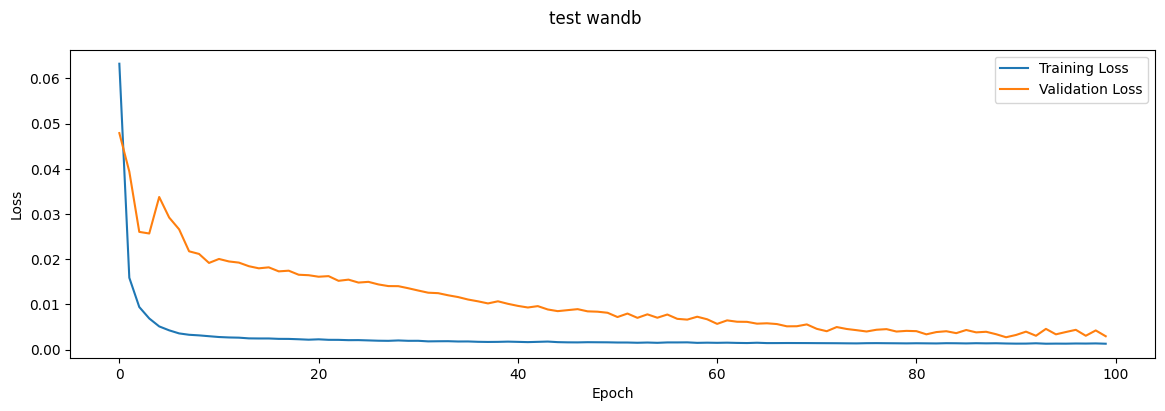

Best train_loss: 0.0013
Best val_loss: 0.0027
Last improvement of val_loss at epoch: 90


In [80]:
# plot the training history
plot_history(comment=config.comment, history=history, wandb=wandb)

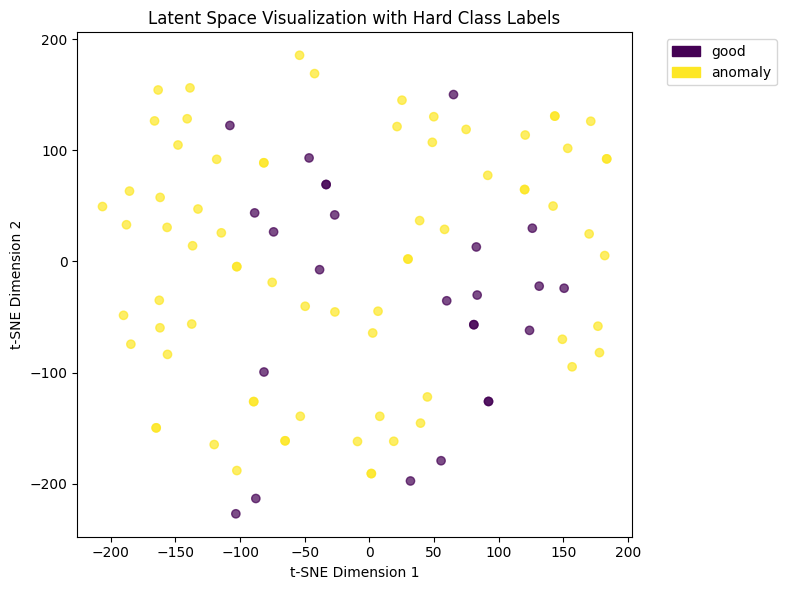

In [83]:
plot_latent_space(autoencoder=autoencoder, test_generator=test_generator, layer_name='bottleneck')


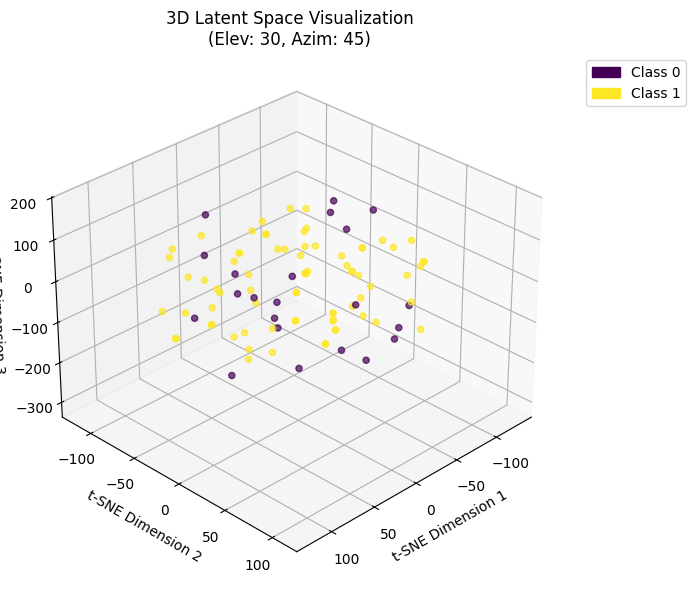

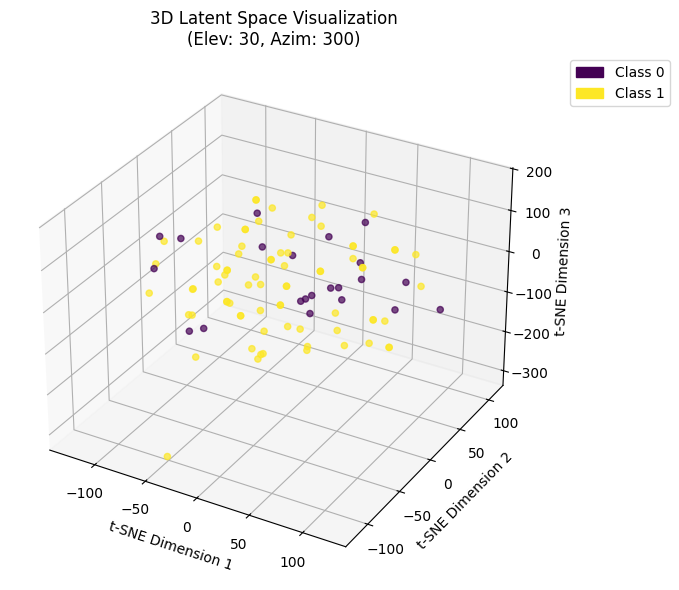

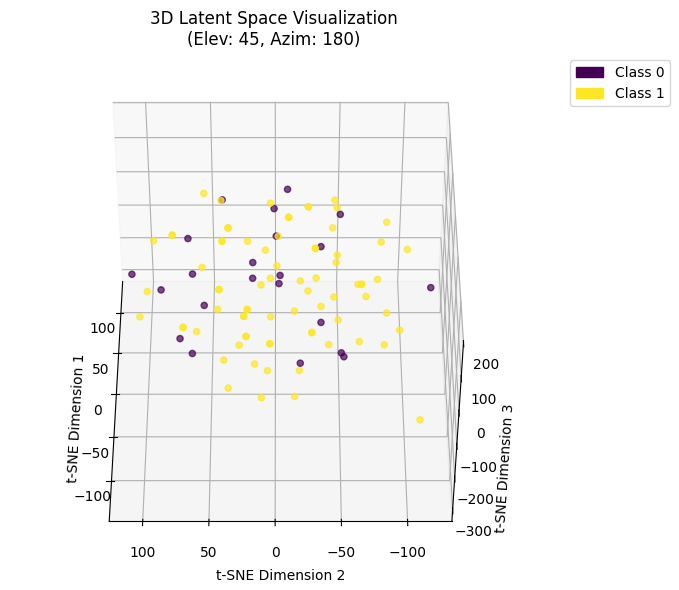

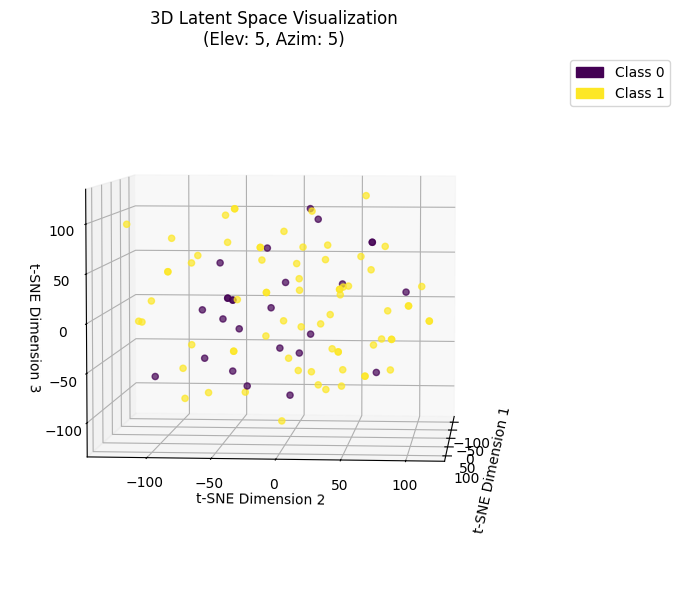

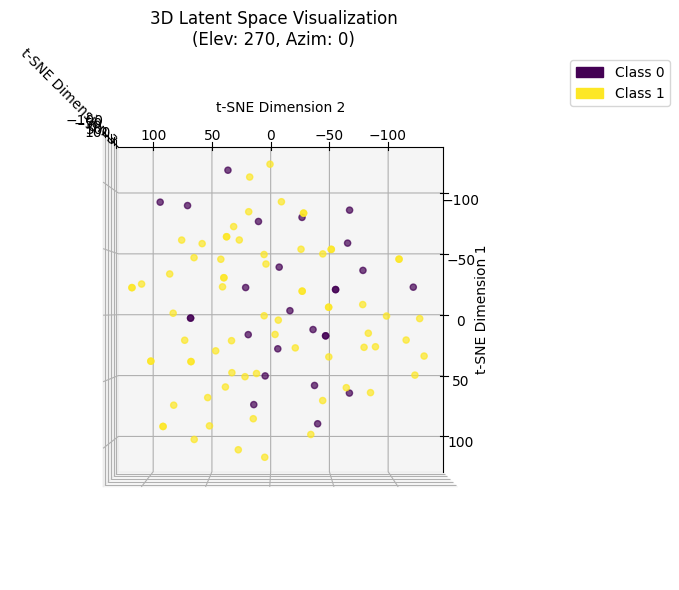

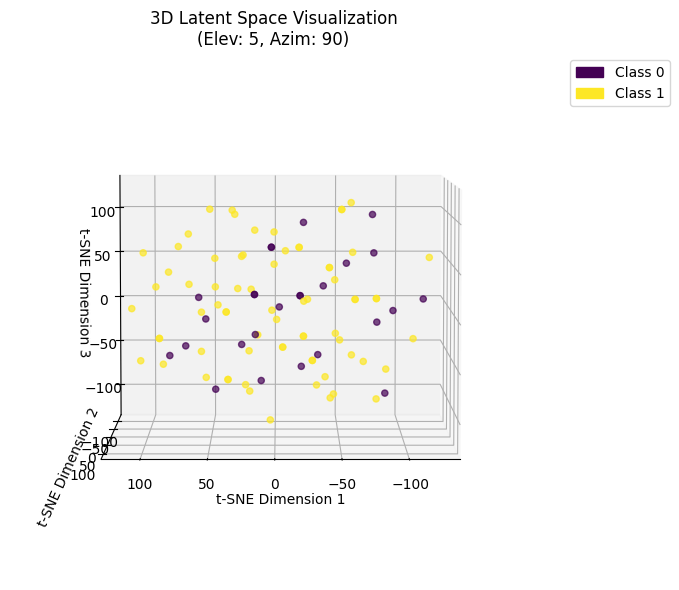

In [84]:
from utils.latent_space import plot_3d_latent_space

angles_1 = [(30, 45), (30, 300), (45, 180)]  # Define viewing angles
plot_3d_latent_space(autoencoder, test_generator, angles=angles_1)

angles_2 = [(5, 5), (270, 0), (5, 90)]  # Define viewing angles
plot_3d_latent_space(autoencoder, test_generator, angles=angles_2)

In [85]:
wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

## Adapted AEKNN version to predict with threshold based on distances in latent space

Accuracy: 0.2653
Confusion Matrix:
 [[21  5]
 [67  5]]
Confusion Matrix:
 [[21  5]
 [67  5]]
Classification Report:
               precision    recall  f1-score   support

      Normal       0.24      0.81      0.37        26
     Anomaly       0.50      0.07      0.12        72

    accuracy                           0.27        98
   macro avg       0.37      0.44      0.25        98
weighted avg       0.43      0.27      0.19        98

F1 Score: 0.1220
AUC: 0.2249
PR-AUC: 0.6083


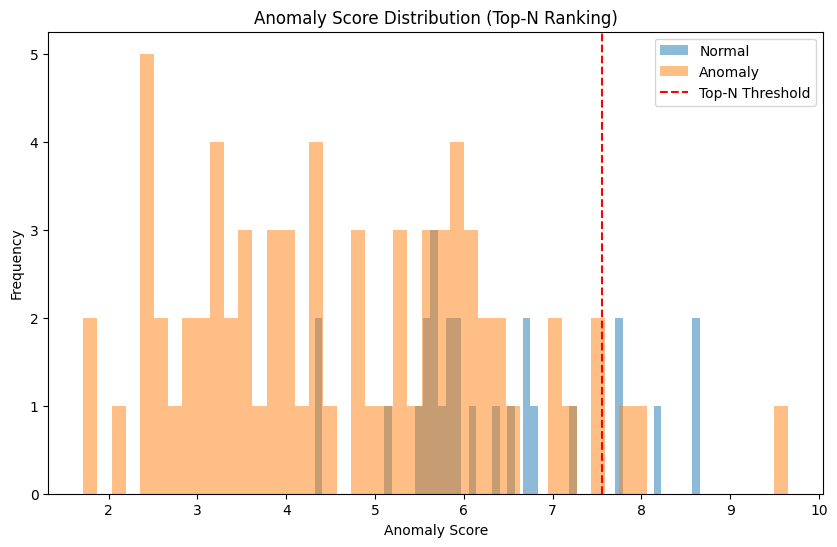

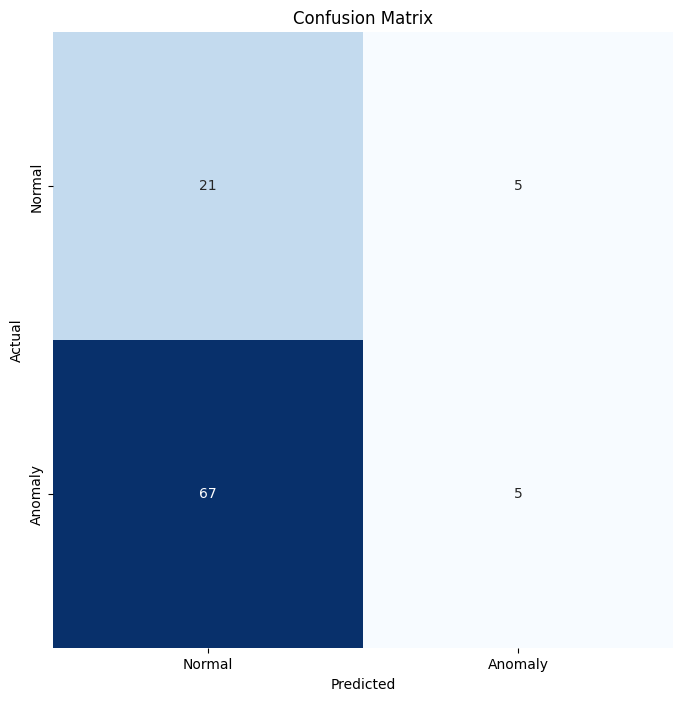

In [91]:
import numpy as np
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    f1_score, 
    roc_auc_score, 
    precision_recall_curve, 
    auc, 
    accuracy_score, 
    mean_squared_error
)
import matplotlib.pyplot as plt
import seaborn as sns

def knn_anomaly_detection(autoencoder, generator, layer_name='bottleneck', n_neighbors=5, top_n=10):
    """
    Apply KNN on latent representations from the autoencoder for anomaly detection using ranking instead of thresholding.
    """
    # Extract latent representations
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
    latent_vectors = []
    labels = []
    reconstruction_errors = []
    
    # Extract latent vectors and reconstruction errors

    steps = len(generator)
    for i in range(steps):
        batch_images, batch_labels = next(generator)
        latent = encoder.predict(batch_images, verbose=0)
        reconstructions = autoencoder.predict(batch_images, verbose=0)
        
        latent_vectors.append(latent.reshape(latent.shape[0], -1))
        labels.append(np.argmax(batch_labels, axis=1))
        
        batch_errors = np.mean(np.square(batch_images - reconstructions), axis=(1, 2, 3))
        reconstruction_errors.extend(batch_errors)
    
    latent_vectors = np.concatenate(latent_vectors)
    labels = np.concatenate(labels)
    reconstruction_errors = np.array(reconstruction_errors)
    
    # Fit KNN on latent vectors
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(latent_vectors)
    
    distances, _ = knn.kneighbors(latent_vectors)
    avg_knn_distances = distances.mean(axis=1)
    
    # Combine reconstruction errors and k-NN distances for anomaly scoring
    anomaly_scores = reconstruction_errors + avg_knn_distances
    
    # Rank data points by anomaly score
    anomaly_indices = np.argsort(anomaly_scores)[-top_n:]  # Top-N highest anomaly scores
    
    predictions = np.zeros_like(anomaly_scores, dtype=int)
    predictions[anomaly_indices] = 1  # Mark Top-N as anomalies
    
    # Map ground-truth labels
    if 'good' in generator.class_indices:
        true_labels = (labels != generator.class_indices['good']).astype(int)
    else:
        raise ValueError("Ensure that the generator contains a 'good' class for normal samples.")
    
    # Evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    cm = confusion_matrix(true_labels, predictions)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", cm)
    
    return {
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "anomaly_scores": anomaly_scores,
        "predictions": predictions,
        "true_labels": true_labels,
        "anomaly_indices": anomaly_indices
    }


def evaluate_knn_results(predictions, true_labels):
    """
    Evaluate KNN predictions with metrics.
    """
    cm = confusion_matrix(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=['Normal', 'Anomaly'])
    f1 = f1_score(true_labels, predictions)
    
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)
    print(f"F1 Score: {f1:.4f}")
    
    return {
        "confusion_matrix": cm,
        "classification_report": report,
        "f1_score": f1
    }


def plot_anomaly_scores(anomaly_scores, true_labels, top_n):
    """
    Plot anomaly scores with the Top-N anomalies highlighted.
    """
    plt.figure(figsize=(10, 6))
    plt.hist([anomaly_scores[i] for i in range(len(true_labels)) if true_labels[i] == 0],
             bins=50, alpha=0.5, label='Normal')
    plt.hist([anomaly_scores[i] for i in range(len(true_labels)) if true_labels[i] == 1],
             bins=50, alpha=0.5, label='Anomaly')
    
    top_n_threshold = np.sort(anomaly_scores)[-top_n]
    plt.axvline(top_n_threshold, color='red', linestyle='--', label='Top-N Threshold')
    
    plt.title('Anomaly Score Distribution (Top-N Ranking)')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


def evaluate_knn_auc(anomaly_scores, true_labels):
    """
    Compute AUC and PR-AUC for KNN anomaly detection.
    """
    auc_score = roc_auc_score(true_labels, anomaly_scores)
    precision, recall, _ = precision_recall_curve(true_labels, anomaly_scores)
    pr_auc = auc(recall, precision)
    
    print(f"AUC: {auc_score:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    
    return {
        "AUC": auc_score,
        "PR_AUC": pr_auc
    }


def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    """
    Plot a confusion matrix using Seaborn heatmap.
    """
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


# Assuming `autoencoder` and `test_generator` are predefined
knn_results = knn_anomaly_detection(
    autoencoder=autoencoder, 
    generator=test_generator,
    layer_name='bottleneck',
    n_neighbors=5,
    top_n=10
)

evaluate_knn_results(knn_results['predictions'], knn_results['true_labels'])
auc_results = evaluate_knn_auc(knn_results['anomaly_scores'], knn_results['true_labels'])
plot_anomaly_scores(knn_results['anomaly_scores'], knn_results['true_labels'], top_n=10)
plot_confusion_matrix(knn_results['confusion_matrix'], ['Normal', 'Anomaly'])


## Original Paper Implementation to take top n's as anomalies

As suggested by Guo et al.:
https://www.wellesu.com/10.1109/icsssm.2018.8464983

Accuracy: 0.37755102040816324
Confusion Matrix:
 [[ 2 22]
 [39 35]]
Confusion Matrix:
 [[ 2 22]
 [39 35]]
Classification Report:
               precision    recall  f1-score   support

      Normal       0.05      0.08      0.06        24
     Anomaly       0.61      0.47      0.53        74

    accuracy                           0.38        98
   macro avg       0.33      0.28      0.30        98
weighted avg       0.48      0.38      0.42        98

F1 Score: 0.5343511450381679
AUC: 0.1610
PR-AUC: 0.5983


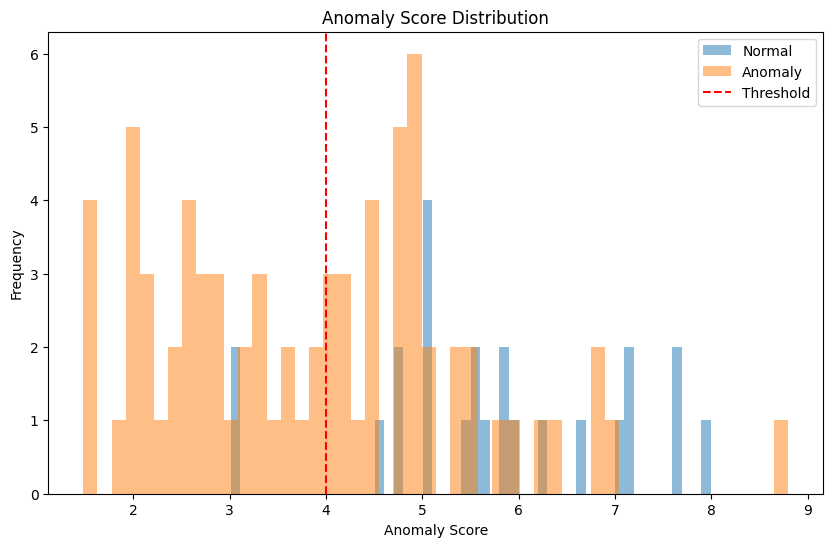

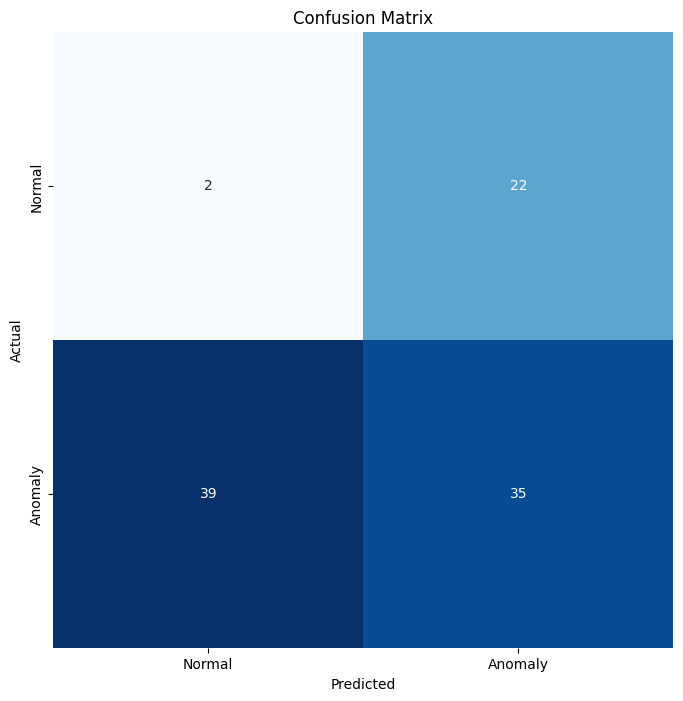

In [95]:
import numpy as np
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    f1_score, 
    roc_auc_score, 
    precision_recall_curve, 
    auc, 
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns


def knn_anomaly_detection(autoencoder, generator, layer_name='bottleneck', n_neighbors=5, threshold=5):
    """
    Apply KNN on latent representations from the autoencoder for anomaly detection.
    """
    # Extract latent representations
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
    latent_vectors = []
    labels = []
    
    # Extract latent vectors
    steps = len(generator)
    for i in range(steps):
        batch_images, batch_labels = next(generator)
        latent = encoder.predict(batch_images, verbose=0)
        latent_vectors.append(latent.reshape(latent.shape[0], -1))
        labels.append(np.argmax(batch_labels, axis=1))
    
    latent_vectors = np.concatenate(latent_vectors)
    labels = np.concatenate(labels)
    
    # Fit KNN on latent vectors
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(latent_vectors)
    
    distances, _ = knn.kneighbors(latent_vectors)
    anomaly_scores = distances.mean(axis=1)
    
    # Anomaly prediction
    predictions = (anomaly_scores > threshold).astype(int)
    true_labels = (labels != generator.class_indices['good']).astype(int)
    
    # Evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    cm = confusion_matrix(true_labels, predictions)
    
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)
    
    return {
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "anomaly_scores": anomaly_scores,
        "predictions": predictions,
        "true_labels": true_labels
    }


def evaluate_knn_results(predictions, true_labels):
    """
    Evaluate KNN predictions with metrics.
    """
    cm = confusion_matrix(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=['Normal', 'Anomaly'])
    f1 = f1_score(true_labels, predictions)
    
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)
    print("F1 Score:", f1)
    
    return {
        "confusion_matrix": cm,
        "classification_report": report,
        "f1_score": f1
    }


def plot_anomaly_scores(anomaly_scores, true_labels, threshold):
    """
    Plot anomaly scores with a threshold.
    """
    plt.figure(figsize=(10, 6))
    plt.hist([anomaly_scores[i] for i in range(len(true_labels)) if true_labels[i] == 0],
             bins=50, alpha=0.5, label='Normal')
    plt.hist([anomaly_scores[i] for i in range(len(true_labels)) if true_labels[i] == 1],
             bins=50, alpha=0.5, label='Anomaly')
    plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
    plt.title('Anomaly Score Distribution')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


def evaluate_knn_auc(anomaly_scores, true_labels):
    """
    Compute AUC and PR-AUC for KNN anomaly detection.
    """
    auc_score = roc_auc_score(true_labels, anomaly_scores)
    precision, recall, _ = precision_recall_curve(true_labels, anomaly_scores)
    pr_auc = auc(recall, precision)
    
    print(f"AUC: {auc_score:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    
    return {
        "AUC": auc_score,
        "PR_AUC": pr_auc
    }


def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    """
    Plot a confusion matrix using Seaborn heatmap.
    """
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


# Assuming `autoencoder` and `test_generator` are predefined
knn_results = knn_anomaly_detection(
    autoencoder=autoencoder, 
    generator=test_generator,
    layer_name='bottleneck',
    n_neighbors=4,
    threshold=4
)

evaluate_knn_results(knn_results['predictions'], knn_results['true_labels'])
auc_results = evaluate_knn_auc(knn_results['anomaly_scores'], knn_results['true_labels'])
plot_anomaly_scores(knn_results['anomaly_scores'], knn_results['true_labels'], threshold=4)
plot_confusion_matrix(knn_results['confusion_matrix'], ['Normal', 'Anomaly'])
